In [538]:
import numpy as np
import tensorflow as tf2
tf = tf2.compat.v1
tf.disable_eager_execution()

In [539]:
# This notebook borrows most of its code from https://github.com/differential-machine-learning/notebooks
# The above repository was written by Anotine Savine

In [540]:
from scipy.stats import norm

def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
    
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    def trainingSet(self, m, anti=True):
            
        returns = np.random.normal(size=[m, 2])

        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        pay = np.maximum(0, S2 - self.K)
        
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        else:
        
            X = S1
            Y = pay
            
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    def testSet(self, lower=0.35, upper=1.65, num=100):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, prices, deltas   

In [541]:
def normalize(x_raw, y_raw, xbar_raw):
    x_mean = x_raw.mean(axis=0)
    x_std = x_raw.std(axis=0)
    x = (x_raw-  x_mean) / x_std
    y_mean = y_raw.mean(axis=0)
    y_std = y_raw.std(axis=0)
    y = (y_raw - y_mean) / y_std
    xbar = xbar_raw / y_std * x_std 

    return x_mean, x_std, x, y_mean, y_std, y, xbar

In [542]:
def twin_network(
    input_dim,
    n_units,
    n_layers):

    # input and initialization
    x = tf.placeholder(shape=[None, input_dim], dtype=tf.float32)
    z = [x]; w = [None]; b = [None]
    w.append(tf.get_variable("w1", [input_dim, n_units], initializer = tf.variance_scaling_initializer(), dtype=tf.float32))
    b.append(tf.get_variable("b1", [n_units], initializer = tf.zeros_initializer(), dtype=tf.float32))
    z.append(z[0] @ w[1] + b[1])

    # hidden layers
    for l in range(1, n_layers): 
        w.append(tf.get_variable("w%d"%(l+1), [n_units, n_units], initializer = tf.variance_scaling_initializer(), dtype=tf.float32))
        b.append(tf.get_variable("b%d"%(l+1), [n_units], initializer = tf.zeros_initializer(), dtype=tf.float32))
        z.append(tf.nn.softplus(z[l]) @ w[l+1] + b[l+1])

    # output
    w.append(tf.get_variable("w"+str(n_layers+1), [n_units, 1], initializer = tf.variance_scaling_initializer(), dtype=tf.float32))
    b.append(tf.get_variable("b"+str(n_layers+1), [1], initializer = tf.zeros_initializer(), dtype=tf.float32))
    z.append(tf.nn.softplus(z[n_layers]) @ w[n_layers+1] + b[n_layers+1]) 
    
    # result
    y = z[n_layers+1]

    # backpropagation
    L = len(z) - 1
    
    zbar = tf.ones_like(z[L])
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(w[l+1])) * tf.nn.sigmoid(z[l])
    xbar = tf.matmul(zbar, tf.transpose(w[1]))

    return x, y, xbar

In [543]:
def train_graph(
    input_dim, 
    n_units, 
    n_layers):

    inputs, predictions, derivative_predictions = twin_network(input_dim, n_units, n_layers)
    labels = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    derivative_labels = tf.placeholder(shape=[None, derivative_predictions.shape[1]], dtype=tf.float32)
    loss = tf.losses.mean_squared_error(labels, predictions) * tf.losses.mean_squared_error(derivative_labels, derivative_predictions)
    learning_rate = tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

    return inputs, labels, derivative_labels, predictions, derivative_predictions, learning_rate, loss, optimizer.minimize(loss)

def one_epoch(
    inputs, labels, derivative_labels,
    lr_placeholder, minimizer,
    x_train, y_train, xbar_train,
    learning_rate, batch_size, session):

    m, n = x_train.shape
    first = 0
    last = min(batch_size, m)

    while first < m:

        session.run(minimizer, feed_dict = {   
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivative_labels: xbar_train[first:last],
            lr_placeholder: learning_rate
        })

        first = last
        last = min(first + batch_size, m)

In [544]:
class NeuralNetwork():

    def __init__(self, x_raw, y_raw, xhat_raw):
        self.session = None
        self.graph = None
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.xhat_raw = xhat_raw
        
    def __del__(self):
        if self.session is not None:
            self.session.close()

    def build(self, n_units, n_layers):
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():

            self.inputs, \
            self.labels, \
            self.derivative_labels, \
            self.predictions, \
            self.derivative_predictions, \
            self.learning_rate, \
            self.loss, \
            self.minimizer = train_graph(self.n, n_units, n_layers)

            self.initializer = tf.global_variables_initializer()

        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)

    def prepare(self, n_units = 20, n_layers = 4):

        #self.x_mean, self.x_std, self.x, self.y_mean, \
        #     self.y_std, self.y, self.xbar = 0, 1, self.x_raw, 0, 1, self.y_raw, self.xhat_raw
        self.x_mean, self.x_std, self.x, self.y_mean, \
             self.y_std, self.y, self.xbar = normalize(self.x_raw, self.y_raw, self.xhat_raw)
        
        self.m, self.n = self.x.shape        
        self.build(n_units, n_layers)

    def train(self,
        learning_rate = 0.1,
        n_epochs = 100,
        batch_size = 256):

        for epoch in range(n_epochs):
        
            one_epoch(
                self.inputs, 
                self.labels, 
                self.derivative_labels,
                self.learning_rate, 
                self.minimizer, 
                self.x, 
                self.y, 
                self.xbar, 
                learning_rate,
                batch_size, 
                self.session)
                
    def predict(self, x):
        x_scaled = (x-self.x_mean) / self.x_std
        y_scaled, xhat_scaled = self.session.run(
            [self.predictions, self.derivative_predictions], 
            feed_dict = {self.inputs: x_scaled})
        y = self.y_mean + self.y_std * y_scaled
        xhat = self.y_std / self.x_std * xhat_scaled
        return y, xhat                                

In [545]:
size = 2 ** 10
bs = BlackScholes()
xTrain, yTrain, dydxTrain = bs.trainingSet(size)
xTest, yTest, dydxTest = bs.testSet(num=100)

In [546]:
regressor = NeuralNetwork(xTrain, yTrain, dydxTrain)
regressor.prepare()
regressor.session.run(regressor.initializer)
regressor.train()
predictions, deltas = regressor.predict(xTest)

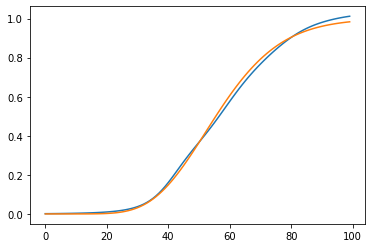

In [547]:
import matplotlib.pyplot as plt

plt.plot(deltas)
plt.plot(dydxTest)

In [548]:
errors = 100 * (deltas - dydxTest)
rmse = np.sqrt((errors ** 2).mean(axis=0)); rmse

array([1.63240257])

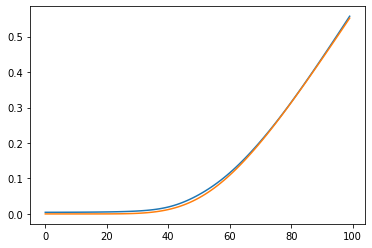

In [549]:
plt.plot(predictions)
plt.plot(yTest)

In [550]:
errors = 100 * (predictions - yTest)
rmse = np.sqrt((errors ** 2).mean(axis=0)); rmse

array([0.55766764])